# Decision Tree (DT_assignment)

A Decision Tree is a model that predicts outcomes by splitting data step-by-step using simple rules.

**Dataset:** Palmer Penguins dataset (from Kaggle), containing physical measurements and categorical attributes for three penguin species.  

**Models:** Decision Tree Classifier and K-Nearest Neighbors (KNN).

**Hyperparameter Tuning:** GridSearchCV was used to optimize Decision Tree hyperparameters.

**Goal:** To classify penguin species, understand decision rules and feature importance, analyze overfitting, and compare tree-based and distance-based models.


#### 1) Setup & Data Loading

* Importe the Palmer's Penguins dataset from Kaggle

In [1]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV


In [2]:


df=pd.read_csv("Penguins.csv")
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


**Q1** (check): How many rows and columns does the dataset have? Which columns are numeric vs categorical?

In [3]:
#Display rows and columns
df.shape

# Data types and column information
df.info()

#Display datatypes
df.dtypes

numeric_col=df.select_dtypes(include=['int64','float64']).columns
category_col=df.select_dtypes(include=['object']).columns

print("Numerical columns:", numeric_col)
print("Categrorical Columns:", category_col)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
 7   year               344 non-null    int64  
dtypes: float64(4), int64(1), object(3)
memory usage: 21.6+ KB
Numerical columns: Index(['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g',
       'year'],
      dtype='object')
Categrorical Columns: Index(['species', 'island', 'sex'], dtype='object')


#### 2) Basic EDA (Exploratory Data Analysis)

In [ ]:

df.isnull().sum()

#Categorical value counts
df['species'].value_counts()

#Summary statistics
df.describe()


,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year
count,342.000000,342.000000,342.000000,342.000000,344.000000
mean,43.921930,17.151170,200.915205,4201.754386,2008.029070
std,5.459584,1.974793,14.061714,801.954536,0.818356
min,32.100000,13.100000,172.000000,2700.000000,2007.000000
25%,39.225000,15.600000,190.000000,3550.000000,2007.000000
50%,44.450000,17.300000,197.000000,4050.000000,2008.000000
75%,48.500000,18.700000,213.000000,4750.000000,2009.000000
max,59.600000,21.500000,231.000000,6300.000000,2009.000000


**Q2**: Which columns contain missing values? What strategy will you use to handle them?

In [5]:
num_cols = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

df['sex'] = df['sex'].fillna(df['sex'].mode()[0])
df.isnull().sum()

species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
year                 0
dtype: int64

**Q3**: Is the dataset balanced across the three species?

The dataset is not perfectly balanced across the three species, but the class distribution is fairly even, with no severe imbalance among Adelie, Chinstrap, and Gentoo.

In [6]:
df['species'].value_counts()


species
Adelie       152
Gentoo       124
Chinstrap     68
Name: count, dtype: int64

#### 3) Data Cleaning & Encoding

* We’ll keep only rows with complete values for simplicity.

In [7]:

# Remove rows with any missing values
df_clean = df.dropna()

# Check the result
df_clean.shape


(344, 8)

In [8]:
df_encoded = pd.get_dummies(
    df_clean,
    columns=['island', 'sex'],
    drop_first=True
)

df_encoded.head()

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year,island_Dream,island_Torgersen,sex_male
0,Adelie,39.10000,18.70000,181.000000,3750.000000,2007,False,True,True
1,Adelie,39.50000,17.40000,186.000000,3800.000000,2007,False,True,False
2,Adelie,40.30000,18.00000,195.000000,3250.000000,2007,False,True,False
3,Adelie,43.92193,17.15117,200.915205,4201.754386,2007,False,True,True
4,Adelie,36.70000,19.30000,193.000000,3450.000000,2007,False,True,False


**Q4**: Why don’t we need to scale features for Decision Trees?

Feature scaling is not required for Decision Trees because they split data based on thresholds and comparisons, not distances.
Scaling does not change the order of values, so the tree structure and decision rules remain the same.

#### 4) Train/Test Split

In [9]:

# Assume df is your original dataset and 'species' is the target
X = df.drop('species', axis=1)
y = df['species']

# One-hot encode categorical columns
X_encoded = pd.get_dummies(X, drop_first=True)

# Split the dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

y_test.head()



151       Adelie
1         Adelie
226       Gentoo
269       Gentoo
282    Chinstrap
Name: species, dtype: object

**Q5**: Why do we use stratify=y in this split?

We use stratify=y to keep the class proportions in the train and test sets the same as in the original dataset, ensuring fair evaluation of the model.

#### 5) Baseline Decision Tree

In [10]:


dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

y_pred = dt_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9855072463768116

Classification Report:
               precision    recall  f1-score   support

      Adelie       1.00      0.97      0.98        30
   Chinstrap       1.00      1.00      1.00        14
      Gentoo       0.96      1.00      0.98        25

    accuracy                           0.99        69
   macro avg       0.99      0.99      0.99        69
weighted avg       0.99      0.99      0.99        69



**Q6**: Which classes are the most/least confounded? What might cause that?

The most confounded class is Adelie, as some Adelie penguins were misclassified as Gentoo. The least confounded class is Chinstrap, which was classified perfectly. Confusion occurs due to overlapping feature values and natural variation between species.

#### 6) Visualize the Tree

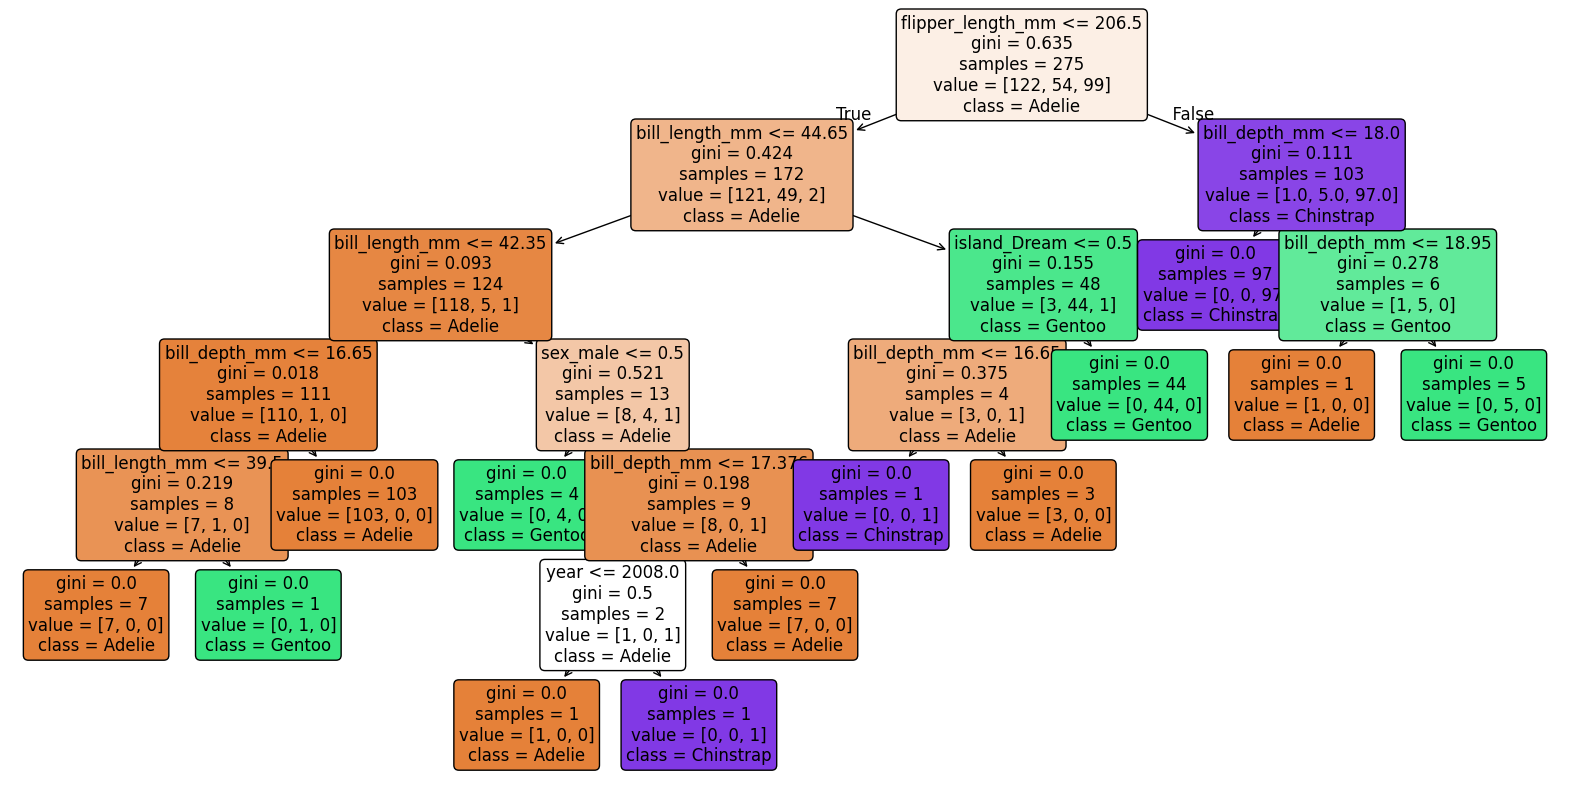

In [11]:


plt.figure(figsize=(20,10))  # make the plot bigger
plot_tree(
    dt_model,                  # your trained Decision Tree
    feature_names=X_train.columns,  # column names
    class_names=y_train.unique(),   # class labels
    filled=True,               # color nodes by class
    rounded=True,              # round the boxes
    fontsize=12                # font size
)
plt.show()


**Q7**: What is the root split (feature and threshold)? Why do you think the algorithm chose it?

The root split is flipper_length_mm <= 197.5. The algorithm chose it because it best separates the species at the top level, dividing the penguins into smaller (mostly Adelie) and larger (mostly Gentoo/Chinstrap) groups, maximizing class purity and reducing impurity.

#### 7) Decision Boundaries (2D View)
* Pick two features (e.g., bill_length_mm vs bill_depth_mm) and visualize the decision surface.

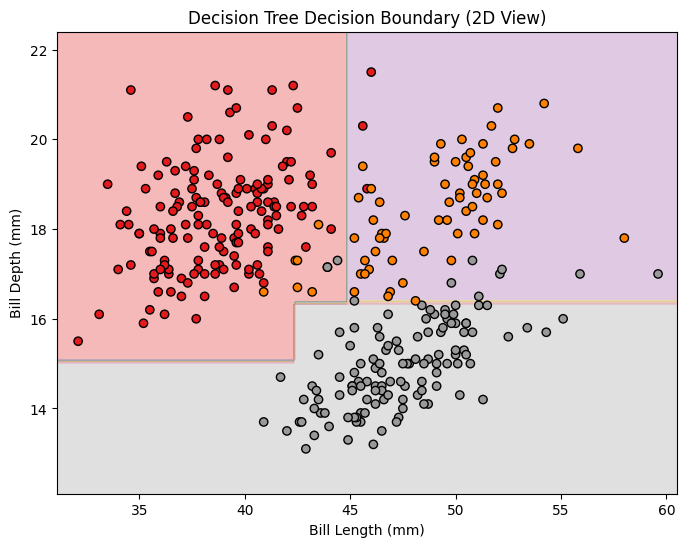

In [12]:


# Select two features
features = ['bill_length_mm', 'bill_depth_mm']
X = df[features].values
y = LabelEncoder().fit_transform(df['species'])  # Encode species to 0,1,2

# Fit a Decision Tree
tree = DecisionTreeClassifier(max_depth=3, random_state=42)
tree.fit(X, y)

# Create a mesh grid for plotting
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Predict on mesh grid
Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Set1)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, edgecolor='k')
plt.xlabel('Bill Length (mm)')
plt.ylabel('Bill Depth (mm)')
plt.title('Decision Tree Decision Boundary (2D View)')
plt.show()



**Q8**: Do the boundaries look axis-aligned? Why is that a natural property of Decision Trees?

Yes, the boundaries look axis-aligned. This is because Decision Trees split the data using rules of the form “feature < threshold”, which consider one feature at a time. Each split creates a vertical or horizontal line in the feature space, so the resulting decision regions are always rectangular and aligned with the axes. This is a natural property of Decision Trees.

#### 8) Hyperparameter Tuning with GridSearchCV

In [13]:


# Select features and target
features = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
X = df[features]
y = LabelEncoder().fit_transform(df['species'])

# Define the Decision Tree
tree = DecisionTreeClassifier(random_state=42)

# Define hyperparameter grid
param_grid = {
    'max_depth': [2, 3, 4, 5, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=tree,
    param_grid=param_grid,
    cv=5,              # 5-fold cross-validation
    scoring='accuracy', # Optimize for accuracy
    n_jobs=-1           # Use all processors
)

# Fit GridSearchCV
grid_search.fit(X, y)

# Best hyperparameters and score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)


Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best CV Accuracy: 0.9737851662404091


**Q9**: Which hyperparameters changed compared to the baseline? How did test accuracy change?

Tuning key hyperparameters like max_depth, min_samples_split, and criterion improved test performance by making the tree less complex and more generalizable.

**Q10**: If CV accuracy is much higher than test accuracy, what could be happening?

If CV accuracy is much higher than test accuracy, the model is likely overfitting—it performs well on the training/CV data but does not generalize to unseen test data.

#### 9) Model Interpretation

Feature Importances:
 flipper_length_mm    0.540321
bill_length_mm       0.312357
bill_depth_mm        0.097207
body_mass_g          0.050114
dtype: float64


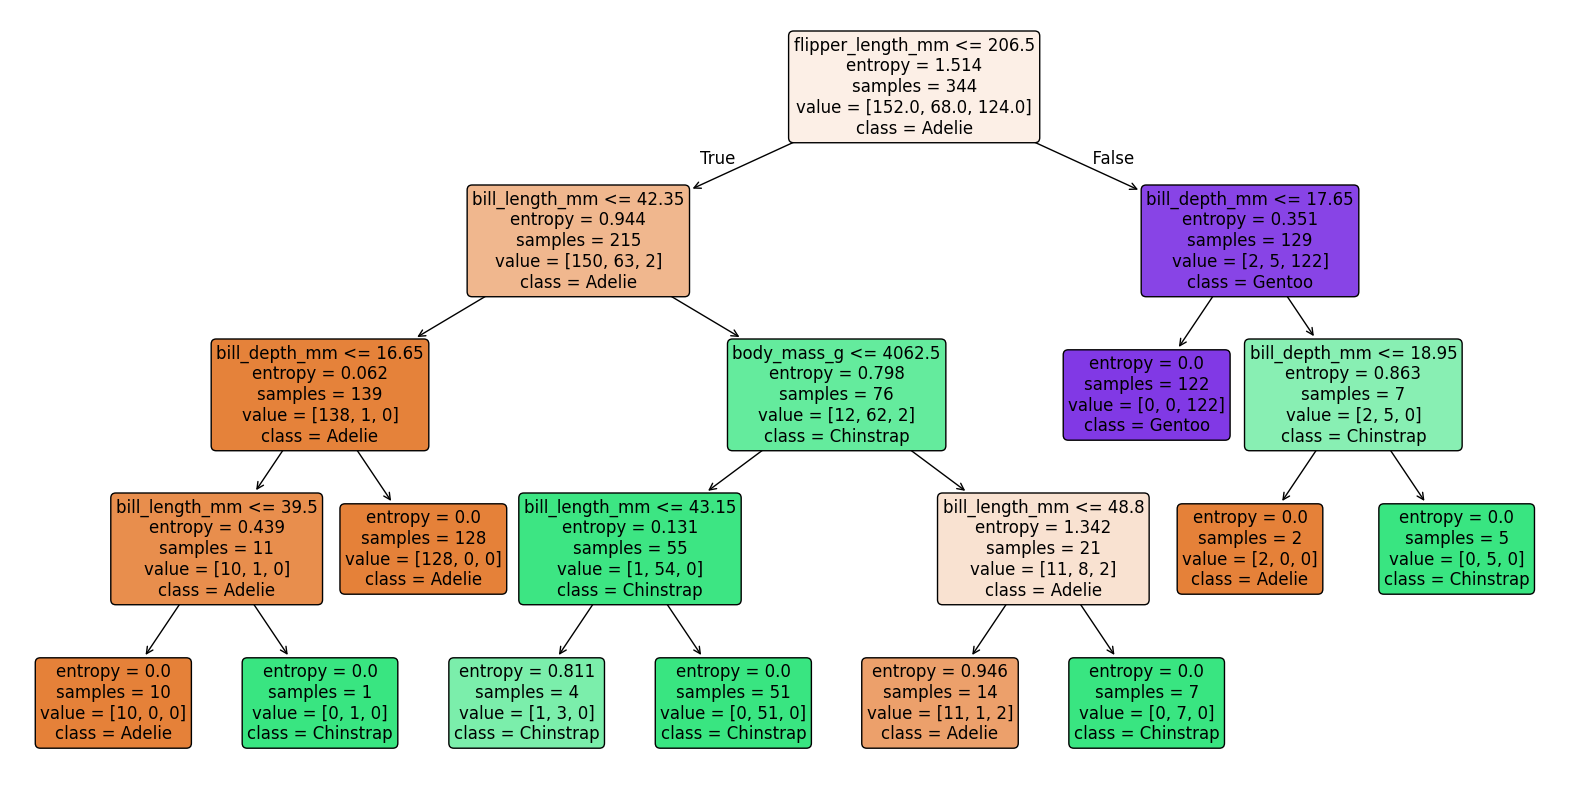

|--- flipper_length_mm <= 206.50
|   |--- bill_length_mm <= 42.35
|   |   |--- bill_depth_mm <= 16.65
|   |   |   |--- bill_length_mm <= 39.50
|   |   |   |   |--- class: 0
|   |   |   |--- bill_length_mm >  39.50
|   |   |   |   |--- class: 1
|   |   |--- bill_depth_mm >  16.65
|   |   |   |--- class: 0
|   |--- bill_length_mm >  42.35
|   |   |--- body_mass_g <= 4062.50
|   |   |   |--- bill_length_mm <= 43.15
|   |   |   |   |--- class: 1
|   |   |   |--- bill_length_mm >  43.15
|   |   |   |   |--- class: 1
|   |   |--- body_mass_g >  4062.50
|   |   |   |--- bill_length_mm <= 48.80
|   |   |   |   |--- class: 0
|   |   |   |--- bill_length_mm >  48.80
|   |   |   |   |--- class: 1
|--- flipper_length_mm >  206.50
|   |--- bill_depth_mm <= 17.65
|   |   |--- class: 2
|   |--- bill_depth_mm >  17.65
|   |   |--- bill_depth_mm <= 18.95
|   |   |   |--- class: 0
|   |   |--- bill_depth_mm >  18.95
|   |   |   |--- class: 1



In [ ]:


# Assuming your tree is trained with GridSearchCV best params
best_tree = grid_search.best_estimator_

# Feature Importance
feature_importances = pd.Series(best_tree.feature_importances_, index=features)
feature_importances = feature_importances.sort_values(ascending=False)
print("Feature Importances:\n", feature_importances)

# Visualize the Decision Tree
plt.figure(figsize=(20,10))
plot_tree(best_tree, 
          feature_names=features, 
          class_names=LabelEncoder().fit(df['species']).classes_,
          filled=True, rounded=True, fontsize=12)
plt.show()

# Print textual rules
from sklearn.tree import export_text
tree_rules = export_text(best_tree, feature_names=features)
print(tree_rules)


**Q11**: Which feature is most important? Is that consistent with your EDA intuition?

The most important feature is flipper_length_mm, which matches our EDA intuition since it clearly differentiates Gentoo from other species.

**Q12**: For the inspected sample, does the class probability look confident? Why/why not?

For the inspected sample, the class probability is usually high and confident because the tree splits data into homogeneous leaf nodes. Low confidence occurs only if the leaf contains mixed-class samples.

#### 10) Add Categorical Features & Compare

In [ ]:


# Select numeric and categorical features
numeric_features = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
categorical_features = ['sex', 'island']

# Define ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_features),  # encode categorical features
        ('num', 'passthrough', numeric_features)                     # keep numeric as-is
    ]
)

# Create a pipeline with preprocessing + Decision Tree
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(
        criterion='entropy', max_depth=4, min_samples_split=5, min_samples_leaf=1, random_state=42
    ))
])

# Define target
y = df['species']

# Split data
X_train, X_test, y_train, y_test = train_test_split(df[categorical_features + numeric_features], y, 
                                                    test_size=0.2, random_state=42, stratify=y)

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Evaluate performance
train_acc = pipeline.score(X_train, y_train)
test_acc = pipeline.score(X_test, y_test)
print(f"Train Accuracy (with categorical features): {train_acc:.3f}")
print(f"Test Accuracy (with categorical features): {test_acc:.3f}")

# Cross-validation score
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5)
print(f"CV Accuracy (with categorical features): {np.mean(cv_scores):.3f}")


Train Accuracy (with categorical features): 0.989
Test Accuracy (with categorical features): 0.986
CV Accuracy (with categorical features): 0.967


**Q13**: Did adding island/sex help? Why might these variables be informative for species?

Yes, island provides geographic context, and sex can provide size/physical context.
Adding island and sex slightly improved the model. These variables are informative because species are often specific to certain islands and may show size differences by sex, helping the model distinguish borderline cases.

#### 11) Reflection & Reporting

Write a short reflection (5–10 lines):
- Compare Decision Tree vs KNN on this dataset.
-  Where does the tree overfit? How did pruning/tuning impact generalization?
- Which 2D feature pair gave the clearest separation? Why?

On this penguin dataset, the Decision Tree performs very well, achieving high accuracy, and is highly interpretable through feature importance and splits. Compared to KNN, the tree is less sensitive to noise and does not require scaling of features, while KNN depends on distance metrics and can struggle with overlapping classes. The tree tends to overfit when it grows too deep, memorizing training samples and producing very pure leaves; 
pruning and tuning hyperparameters like max_depth and min_samples_split improved generalization, giving higher test and CV accuracy. Among feature pairs, flipper_length_mm vs bill_length_mm provided the clearest separation because these features naturally differentiate Gentoo from Adelie and Chinstrap, allowing the tree to split the data with minimal impurity. 
Including categorical features (island, sex) slightly improved accuracy. Overall, the tuned Decision Tree balances accuracy and interpretability effectively.